# Comparison of Soft Masks (b/w Mask RCNN and Mask Prop)

In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
from keras.backend import tf

# static GPU memory allocation for tensorflow (reserve some GPU for PyTorch optical flow)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.75)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

from image_seg.model import MaskRCNN
from mask_prop.mask_propagation import MaskPropagation

# directories & files
logs_dir = '../logs'
davis_dataset_root = '../../data/DAVIS'
mrcnn_weights_path = '../../MaskTrack_RCNN/INITIAL_TRAINING_LOGS/wad20180712T0357_RUN2_ALL/mask_rcnn_wad_0020.h5'
pwc_net_weights_path = '../opt_flow/pwc_net.pth.tar'
mp_weights_path = '../mask_prop/davis_unet_weights.h5'

Using TensorFlow backend.


Project Directory: /home/shared/project/MultiSeg
Data Directory: /home/shared/project/MultiSeg/dataset/wad
Logs and Model Directory: /home/shared/project/MultiSeg/logs


In [2]:
from train.davis_data import MaskPropDavisDataset
from skimage.io import imread
from mask_prop.mask_propagation import pad_image

dataset = MaskPropDavisDataset(davis_dataset_root, "480p", val_videos=[
    "car-shadow", "breakdance", "camel", "scooter-black", "libby", "drift-straight"
])

img_prev, img_curr, mask_prev, mask_curr =\
    list(map(pad_image, map(imread, dataset.get_random_pair(val=False, random_state=17))))


In [56]:
def print_statistics(mask):
    vector = mask.ravel()
    
    print()
    print(f'Maximum:\t {np.max(vector)}')
    print(f'Minimum:\t {np.min(vector)}')
    print(f'Mean:\t\t {np.mean(vector)}')
    print(f'Std Dev:\t {np.std(vector)}')
    print(f'Median:\t\t {np.median(vector)}')
    print()

## Mask RCNN Inference

Processing 1 images
image                    shape: (480, 864, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 48)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


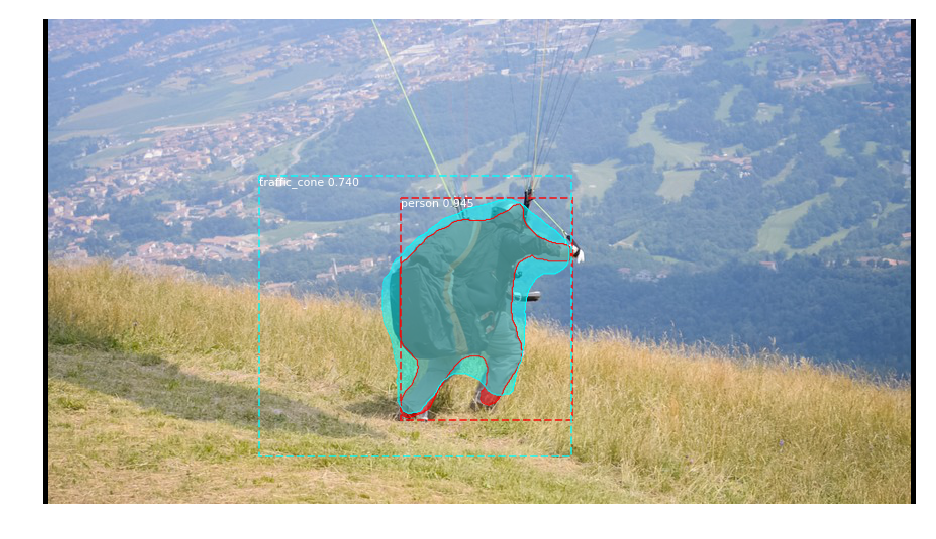

In [21]:
from image_seg import visualize
from train.wad_data import WadConfig, index_to_class_names


# WAD Configuration
class WADInferenceConfig(WadConfig):
    BATCH_SIZE = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0
    
    
wad_config = WADInferenceConfig()

# Create model in inference mode
mrcnn = MaskRCNN(mode='inference', config=wad_config, model_dir=logs_dir)

mrcnn.load_weights(mrcnn_weights_path, by_name=True)

results = mrcnn.detect([img_curr], verbose=1)[0]

visualize.display_instances(img_curr, results['rois'], results['masks'], results['class_ids'], 
                            index_to_class_names, results['scores'])

(480, 864)


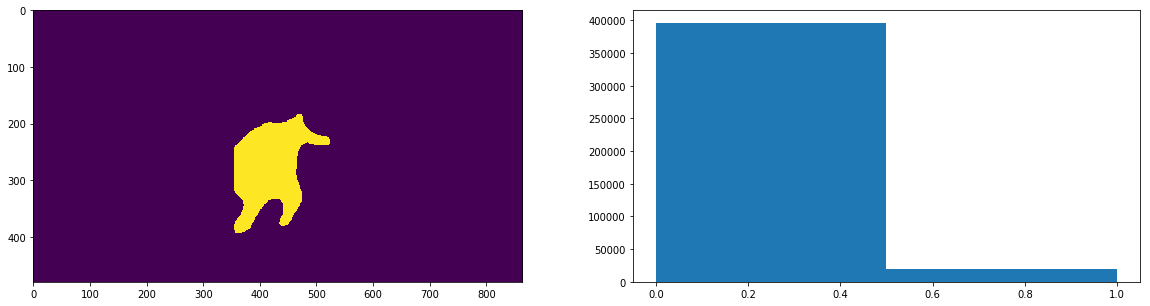

[[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]]


In [50]:
segmented_mask = results['masks'][..., 0]

print(segmented_mask.shape)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].set_title('first segmented mask')
axes[0].imshow(segmented_mask)
axes[1].set_title('binary histogram')
axes[1].hist(segmented_mask.ravel(), bins=2)

plt.show()

print(segmented_mask)

## Mask Propagation Inference

In [5]:
from opt_flow.pwc_net_wrapper import PWCNetWrapper

optical_flow = PWCNetWrapper(pwc_net_weights_path)
mp = MaskPropagation(mp_weights_path

# get the flow field
flow_field = optical_flow.infer_flow_field(img_prev, img_curr)
flow_field_x, flow_field_y = flow_field[:, :, 0], flow_field[:, :, 1]
flow_field[:, :, 0] = (flow_field_x - flow_field_x.mean()) / flow_field_x.std()
flow_field[:, :, 1] = (flow_field_y - flow_field_y.mean()) / flow_field_y.std()

inputs = np.stack([mask_prev, flow_field[:, :, 0], flow_field[:, :, 1]], axis=2)
inputs = np.expand_dims(inputs, axis=0)

# propagate the mask using flow field and previous mask
propagated_mask = mp.predict(inputs)
propagated_mask = propagated_mask[0, :, :, 0]

(480, 864)


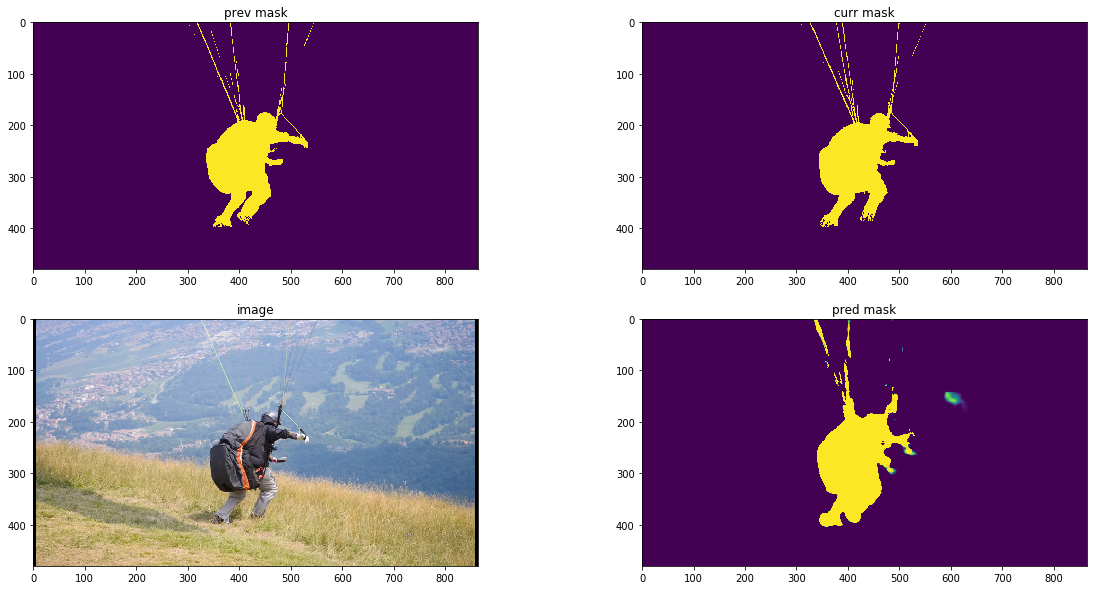

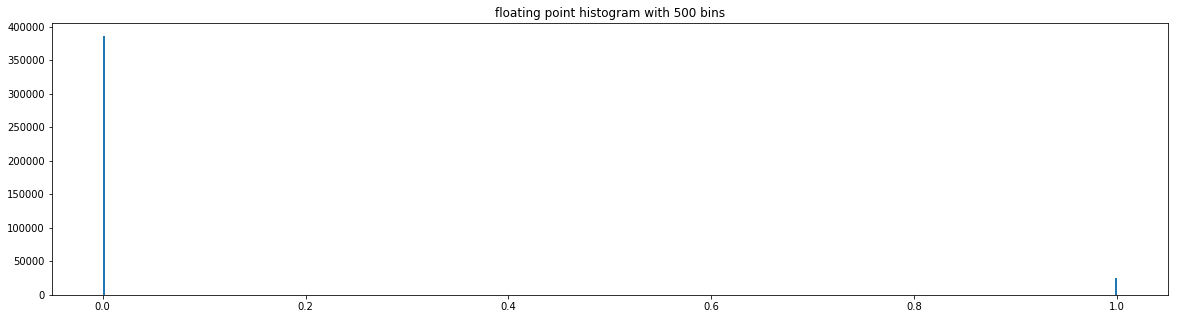

[[  2.68076139e-04   4.46192280e-06   8.08266236e-08 ...,   3.58689221e-08
    3.24722862e-07   4.02294645e-05]
 [  1.75602891e-05   3.00764128e-07   3.28779706e-08 ...,   8.18743917e-09
    1.61461332e-06   4.01637662e-05]
 [  3.55705970e-06   6.04335568e-08   7.94439803e-09 ...,   1.09855458e-09
    4.03472136e-08   8.35616504e-07]
 ..., 
 [  9.55856667e-05   2.58035689e-05   2.30413116e-05 ...,   6.55704824e-08
    9.00848960e-08   1.50982178e-05]
 [  2.82084889e-04   3.10829382e-05   2.91043598e-05 ...,   6.25488212e-08
    3.45643315e-07   1.13005490e-05]
 [  6.24272740e-04   2.60065397e-04   2.21735827e-04 ...,   2.75967454e-06
    1.33745043e-05   3.01024440e-04]]

Maximum:	 1.0
Minimum:	 0.0
Mean:		 0.06324173510074615
Std Dev:	 0.24166961014270782
Median:		 1.8493193465474178e-07



In [57]:
print(propagated_mask.shape)

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0][0].imshow(mask_prev)
axes[0][0].set_title('prev mask')
axes[0][1].imshow(mask_curr)
axes[0][1].set_title('curr mask')
axes[1][0].imshow(img_curr)
axes[1][0].set_title('image')
axes[1][1].imshow(propagated_mask)
axes[1][1].set_title('pred mask')
plt.show()

plt.figure(figsize=(20, 5))
plt.title('floating point histogram with 500 bins')
plt.hist(propagated_mask.ravel(), bins=500)
plt.show()

print(propagated_mask)

print_statistics(propagated_mask)